# Librerías

In [2]:
import pandas as pd
import numpy as np

import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from varclushi import VarClusHi

from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

#from scikitplot.metrics import plot_roc_curve

In [3]:
pd.set_option('display.max_columns',100)

In [4]:
pd.options.display.float_format = '{:,.6f}'.format

# Extracción de datos

In [6]:
ruta  = 'data/estaciones'

In [7]:
lst_archivos = os.listdir( ruta )

In [10]:
archi = [ a for a in  lst_archivos if a[-3:] == 'csv']

In [18]:
df = pd.read_csv( os.path.join( ruta , archi[0]  ) , sep='|' )

In [20]:
df.sample(10)

,afluencia,id_estacion,t
195307,583168,Est00067,67
227834,23826,Est00138,360
37632,152497,Est00011,228
25907,425439,Est00114,21
62523,188247,Est00123,632
25379,52836,Est00118,664
61056,138583,Est00160,496
219131,130865,Est00050,252
59440,54441,Est00293,531
225355,115332,Est00119,348


# Planteamiento de los problemas

Clara nos solicitó resolver esta problemática para todas las estaciones a nivel nacional:
1) Pronósticar la afluencia de cualquier estación
2) Identificar si alguna estación será de alta demanda o no ( 0 = Baja demanda , 1 = Alta demanda  )

Las dos problemáticas son de tipo MODELOS SUPERVISADOS
1) Es un modelo de regresión
2) Es un modelo de clasificación

# Limpieza / Exploración

In [21]:
df.dtypes

afluencia       int64
id_estacion    object
t               int64
dtype: object

In [24]:
df['id_estacion'].value_counts()

id_estacion
Est00185    700
Est00194    700
Est00007    700
Est00117    700
Est00251    700
           ... 
Est00052    699
Est00239    699
Est00104    699
Est00250    699
Est00320    699
Name: count, Length: 390, dtype: int64

# Variables

In [33]:
um = ['id_estacion']
t_min = df['t'].min() 
t_max = df['t'].max()
cols = range( t_min , t_max+1 )

In [36]:
t_min, t_max

(np.int64(1), np.int64(700))

In [37]:
df_piv = df.pivot_table( index=um , columns='t' , values='afluencia', aggfunc ='sum' ).reset_index()

In [38]:
df_piv

t,id_estacion,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700
0,Est00000,"39,059.000000","74,700.000000","44,356.000000","237,597.000000","235,918.000000","181,140.000000","257,563.000000","257,761.000000","142,208.000000","68,416.000000","233,986.000000","297,135.000000","244,377.000000","213,395.000000","284,806.000000","191,722.000000","90,565.000000","284,391.000000","286,159.000000","265,663.000000","308,424.000000","278,298.000000","145,315.000000","114,979.000000","246,934.000000","196,434.000000","282,779.000000","257,312.000000","337,761.000000","193,769.000000","72,877.000000","99,671.000000","257,584.000000","334,456.000000","249,029.000000","309,451.000000","208,369.000000","82,072.000000","263,976.000000","347,139.000000","247,580.000000","319,318.000000","353,565.000000","146,118.000000","99,440.000000","365,255.000000","295,789.000000","267,934.000000","276,156.000000",...,"301,889.000000","369,308.000000","271,865.000000","123,949.000000","424,303.000000","328,247.000000","308,635.000000","297,251.000000","308,274.000000","236,271.000000","106,873.000000","387,071.000000","332,824.000000","309,247.000000","313,830.000000","354,558.000000","247,682.000000","115,516.000000","405,568.000000","315,027.000000","159,651.000000","329,464.000000","321,943.000000","222,915.000000","113,659.000000","379,849.000000","320,937.000000","309,172.000000","297,774.000000","320,161.000000","238,135.000000","122,480.000000","414,973.000000","396,088.000000","373,579.000000","336,115.000000","329,641.000000","248,852.000000","112,633.000000","139,188.000000","370,097.000000","305,425.000000","311,695.000000","325,139.000000","240,916.000000","110,586.000000","394,055.000000","343,256.000000","374,973.000000","359,923.000000"
1,Est00001,"48,321.000000","368,193.000000","293,510.000000","295,068.000000","200,780.000000","236,938.000000","152,211.000000","283,677.000000","114,380.000000","365,221.000000","290,042.000000","143,983.000000","91,633.000000","242,494.000000","269,491.000000","330,437.000000","305,608.000000","287,825.000000","165,424.000000","109,593.000000","251,436.000000","285,139.000000","258,189.000000","282,038.000000","266,003.000000","165,798.000000","94,217.000000","355,734.000000","355,945.000000","314,483.000000","342,847.000000","124,799.000000","240,535.000000","213,952.000000","316,645.000000","305,506.000000","103,282.000000","149,137.000000","262,466.000000","345,323.000000","289,464.000000","153,082.000000","284,255.000000","362,637.000000","387,397.000000","376,435.000000","219,807.000000","120,562.000000","355,721.000000",...,"102,962.000000","96,604.000000","115,183.000000","102,452.000000","123,507.000000","97,685.000000","61,051.000000","99,263.000000","104,064.000000","102,922.000000","124,391.000000","119,617.000000","98,093.000000","61,691.000000","99,549.000000","113,755.000000","109,559.000000","103,085.000000","108,165.000000","109,552.000000","51,538.000000","64,696.000000","104,098.000000","107,770.000000","104,071.000000","117,889.000000","94,618.000000","53,455.000000","105,043.000000","109,681.000000","104,642.000000","112,803.000000","122,051.000000","95,292.000000","61,500.000000","74,516.000000","105,091.000000","101,453.000000","107,478.000000","116,556.000000","97,849.000000","51,293.000000","93,265.000000","116,890.000000","116,176.000000","109,783.000000","123,092.000000","79,045.000000","66,206.000000","94,625.000000"
2,Est00002,"17,515.000000","49,586.000000","49,395.000000","42,017.000000","27,076.000000","38,617.000000","33,000.000000","43,166.000000","20,616.000000","54,652.000000","40,779.000000","31,959.000000","21,609.000000","42,513.000000","44,044.000000","46,825.000000","43,221.00000

# Funciones

# Funciones Agregación

In [67]:
def sum_inc(l):
    return sum( [ int(y>x) for x,y in zip(l , l[1:] ) ] )

def sum_dec(l):
    return sum( [ int(y<x) for x,y in zip(l , l[1:] ) ] )

def media_inc(l):
    return np.mean( [ int(y>x) for x,y in zip(l , l[1:] ) ] )

def media_dec(l):
    return np.mean( [ int(y<x) for x,y in zip(l , l[1:] ) ] )

def delta_min(l):
    try:
        return min( [ float( y-x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def delta_max(l):
    try:
        return  max( [ float( y-x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def delta_mean(l):
    try:
        return  np.mean( [ float( y-x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def delta_desv(l):
    try:
        return  np.std( [ float( y-x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan
    
def pct_delta_min(l):
    try:
        return  min( [ float( (y-x)/x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def pct_delta_max(l):
    try:
        return  max( [ float( (y-x)/x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def pct_delta_mean(l):
    try:
        return  np.mean( [ float( (y-x)/x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def pct_delta_desv(l):
    try:
        return  np.std( [ float( (y-x)/x ) for x,y in zip(l , l[1:] ) ]  )
    except:
        return np.nan

def max_racha_inc(l):
    return max( [ len(i) for i in "".join([ str( int(y>x)  ) for x,y in zip(l,l[1:])  ]).split('0')  ]   )

def max_racha_dec(l):
    return max( [ len(i) for i in "".join([ str( int(y<x)  ) for x,y in zip(l,l[1:])  ]).split('0')  ]   )

def media_racha_inc(l):
    return np.mean( [ len(i) for i in "".join([ str( int(y>x)  ) for x,y in zip(l,l[1:])  ]).split('0')  ]   )

def media_racha_dec(l):
    return np.mean( [ len(i) for i in "".join([ str( int(y<x)  ) for x,y in zip(l,l[1:])  ]).split('0')  ]   )    

###### Inicio Ejemplo en excel

In [71]:
lst = [1500,1497,2000,3000,3500,4000,1286]

In [72]:
media_racha_inc(lst)

np.float64(1.3333333333333333)

In [ ]:
sum_inc(lst)
sum_dec(lst)
media_inc(lst)
media_dec(lst)
delta_min(lst)
delta_max(lst)
delta_mean(lst)
delta_desv(lst)
pct_delta_min(lst)
pct_delta_max(lst)
pct_delta_mean(lst)
pct_delta_desv(lst)
max_racha_inc(lst)
max_racha_dec(lst)
media_racha_inc(lst)
media_racha_dec(lst)

###### Fin Ejemplo en excel

In [90]:
lst_func = [ 'sum','min','mean','max','std', 
            sum_inc , sum_dec ,  media_inc, media_dec,
            delta_min, delta_max, delta_mean, delta_desv,
            pct_delta_min, pct_delta_max, pct_delta_mean, pct_delta_desv,
            max_racha_inc, max_racha_dec, media_racha_inc, media_racha_dec ]

# Ventanas de tiempo

In [75]:
vdes = 1
vobs = 10

anclai = t_min + vobs -1
anclaf = t_max - vdes

In [76]:
print("Ventanas: ", vdes , " --- ", vobs)

Ventanas:  1  ---  10


In [77]:
print("Anclas: ", anclai , " --- ", anclaf)

Anclas:  10  ---  699


# Matriz de predictoras

In [91]:
%%time
lst_aux = []

for ancla in range(anclai, anclaf + 1):
#for ancla in range(anclai, 15):

    print("Intervalo: ",ancla - anclai, ancla , " Para pronosticar: ", ancla+vdes)

    aux = df[ ( df['t']>  ancla - anclai ) &
              ( df['t']<= ancla )  ].reset_index(drop=True)

    aux = aux.pivot_table( index = um , 
                           values = 'afluencia', 
                           aggfunc = lst_func )
    
    aux.columns = [ f'v_{i}_{j}' for i,j in aux.columns ]

    aux.insert( 0 , 'ancla' , ancla )
     
    aux.reset_index(inplace=True)

    #print("Tamaño del dataframe: ",aux.shape)
    #display(aux.head(3))

    lst_aux.append(aux)

Intervalo:  0 10  Para pronosticar:  11
Intervalo:  1 11  Para pronosticar:  12
Intervalo:  2 12  Para pronosticar:  13
Intervalo:  3 13  Para pronosticar:  14
Intervalo:  4 14  Para pronosticar:  15
Intervalo:  5 15  Para pronosticar:  16
Intervalo:  6 16  Para pronosticar:  17
Intervalo:  7 17  Para pronosticar:  18
Intervalo:  8 18  Para pronosticar:  19
Intervalo:  9 19  Para pronosticar:  20
Intervalo:  10 20  Para pronosticar:  21
Intervalo:  11 21  Para pronosticar:  22
Intervalo:  12 22  Para pronosticar:  23
Intervalo:  13 23  Para pronosticar:  24
Intervalo:  14 24  Para pronosticar:  25
Intervalo:  15 25  Para pronosticar:  26
Intervalo:  16 26  Para pronosticar:  27
Intervalo:  17 27  Para pronosticar:  28
Intervalo:  18 28  Para pronosticar:  29
Intervalo:  19 29  Para pronosticar:  30
Intervalo:  20 30  Para pronosticar:  31
Intervalo:  21 31  Para pronosticar:  32
Intervalo:  22 32  Para pronosticar:  33
Intervalo:  23 33  Para pronosticar:  34
Intervalo:  24 34  Para pr

In [92]:
X = pd.concat( lst_aux  , ignore_index=True)

In [93]:
X

,id_estacion,ancla,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia
0,Est00000,10,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667
1,Est00001,10,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000
2,Est00002,10,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000
3,Est00003,10,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000
4,Est00004,10,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,Est00385,699,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
269096,Est00386,699,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667
269097,Est00387,699,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667
269098,Est00388,699,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571


# Vector Solución

In [101]:
%%time
lst_aux = []

for ancla in range(anclai, anclaf +1):
#for ancla in range(anclai, 15):

    print("Intervalo: ", ancla - anclai , ancla , " Para pronosticar: ",ancla+vdes)

    aux = df[ (df['t'] > ancla-anclai) & (df['t'] <= ancla + vdes ) ].reset_index(drop=True)
    aux =  aux.pivot_table( index= um , columns='t', values='afluencia' )

    #display(aux)
    aux['y'] = aux[ ancla + vdes ]
    #print("\n")
    #display(aux)
    #print("\n")

    aux = aux[['y']]

    aux.insert( 0 , 'ancla', ancla)

    aux.reset_index(inplace=True)

    lst_aux.append(aux)

Intervalo:  0 10  Para pronosticar:  11
Intervalo:  1 11  Para pronosticar:  12
Intervalo:  2 12  Para pronosticar:  13
Intervalo:  3 13  Para pronosticar:  14
Intervalo:  4 14  Para pronosticar:  15
Intervalo:  5 15  Para pronosticar:  16
Intervalo:  6 16  Para pronosticar:  17
Intervalo:  7 17  Para pronosticar:  18
Intervalo:  8 18  Para pronosticar:  19
Intervalo:  9 19  Para pronosticar:  20
Intervalo:  10 20  Para pronosticar:  21
Intervalo:  11 21  Para pronosticar:  22
Intervalo:  12 22  Para pronosticar:  23
Intervalo:  13 23  Para pronosticar:  24
Intervalo:  14 24  Para pronosticar:  25
Intervalo:  15 25  Para pronosticar:  26
Intervalo:  16 26  Para pronosticar:  27
Intervalo:  17 27  Para pronosticar:  28
Intervalo:  18 28  Para pronosticar:  29
Intervalo:  19 29  Para pronosticar:  30
Intervalo:  20 30  Para pronosticar:  31
Intervalo:  21 31  Para pronosticar:  32
Intervalo:  22 32  Para pronosticar:  33
Intervalo:  23 33  Para pronosticar:  34
Intervalo:  24 34  Para pr

In [102]:
y = pd.concat( lst_aux , ignore_index=True )

In [104]:
X.shape , y.shape

((269100, 23), (269100, 3))

In [106]:
y

t,id_estacion,ancla,y
0,Est00000,10,"233,986.000000"
1,Est00001,10,"290,042.000000"
2,Est00002,10,"40,779.000000"
3,Est00003,10,"232,123.000000"
4,Est00004,10,"228,464.000000"
...,...,...,...
269095,Est00385,699,405.000000
269096,Est00386,699,"64,261.000000"
269097,Est00387,699,NaN
269098,Est00388,699,"266,479.000000"


# TAD preliminar

In [110]:
tad = X.merge( y , on = ['id_estacion','ancla'] , how='inner' )

In [111]:
tad

,id_estacion,ancla,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia,y
0,Est00000,10,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667,"233,986.000000"
1,Est00001,10,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000,"290,042.000000"
2,Est00002,10,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000,"40,779.000000"
3,Est00003,10,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000,"232,123.000000"
4,Est00004,10,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000,"228,464.000000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,Est00385,699,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,405.000000
269096,Est00386,699,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667,"64,261.000000"
269097,Est00387,699,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667,NaN
269098,Est00388,699,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571,"266,479.000000"


<Axes: >

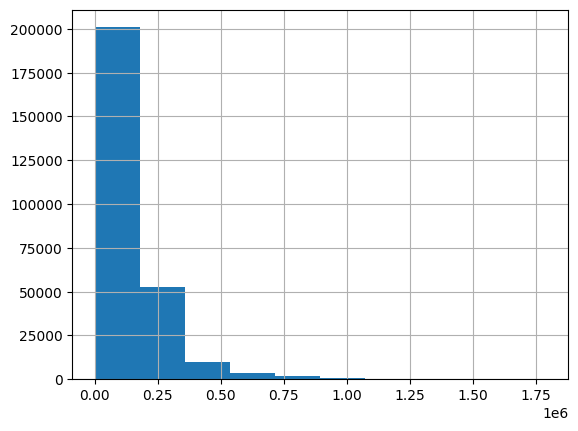

In [112]:
tad['y'].hist()

In [114]:
tad['y2'] = np.where(tad['y'] <= 100000,0,1)

In [115]:
tad

,id_estacion,ancla,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia,y,y2
0,Est00000,10,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667,"233,986.000000",1
1,Est00001,10,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000,"290,042.000000",1
2,Est00002,10,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000,"40,779.000000",0
3,Est00003,10,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000,"232,123.000000",1
4,Est00004,10,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000,"228,464.000000",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,Est00385,699,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,405.000000,0
269096,Est00386,699,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667,"64,261.000000",0
269097,Est00387,699,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667,NaN,1
269098,Est00388,699,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571,"266,479.000000",1


## Persistir TAD

In [116]:
tad.to_parquet( 'resultados/tad_preliminar_estaciones.parquet' )

# Análisis Exploratorio

### Variables Continuas / Numéricas